# インフレとマネーストック

<div name="html-admonition" style="font-size: 0.8em">
<input type="button" onclick="location.href='https://translate.google.com/translate?hl=&sl=ja&tl=en&u='+window.location;" value="Google translation" style="color:#ffffff;background-color:#008080; height:25px" onmouseover="this.style.background='#99ccff'" onmouseout="this.style.background='#008080'"/> in English or the language of your choice.
</div><br>

In [1]:
import japanize_matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import py4macro
import statsmodels.formula.api as smf

# numpy v1の表示を使用
np.set_printoptions(legacy='1.21')
# 警告メッセージを非表示
import warnings
warnings.filterwarnings("ignore")

## はじめに

前章に続けて、経済の「真のメカニズム」の反映としてデータに現れる何らかのパターンを考察する。
ここでは、マネーストックとインフレーションとの関係に着目しデータの特徴を考える。

この２つの変数の関係を示す考え方として、貨幣数量説があり、次式で表される。

$$
P_tY_t=M_tV_t
$$ (eq:11-qtm)

* $P_t$：一般物価水準
    * ある期間（1年間）で取引された財の集計物価水準
* $Y_t$：実質支出（GDP）
    * ある期間（1年間）で取引された財に対する実質支出額
* $M_t$：マネーストック
    * ある期間（1年間）平均で流通した貨幣量
* $V_t$：貨幣の流通速度
    * ある期間（1年間）平均で貨幣１単位が何回使用されたかを示す

式[](eq:11-qtm)に対数を取り時間微分すると次式となる。

$$
\pi_t+g_t=m_t+v_t
$$ (eq:11-qtm_growth)

ここで
* $\pi_t=\dfrac{\dot{P}_t}{P_t}$：インフレ率
* $g_t=\dfrac{\dot{Y_t}}{Y_t}$：実質GDPの成長率
* $m_t\equiv\dfrac{\dot{M}_t}{M_t}$：マネーストックの増加率
* $v_t=\dfrac{\dot{V}_t}{V_t}$：貨幣の流通速度の変化率

式[](eq:11-qtm)は恒等式であり，式[](eq:11-qtm_growth)も常に成り立つ関係である。ここで長期均衡を考えてみよう。GDPは供給サイドで決定され，成長率は一定（$g_t=\overline{g}$）としよう（ソロー・モデルを考えてみよう）。更に貨幣の流通速度は一定とする。この仮定のもと式[](eq:11-qtm_growth)は次式としてまとめることができる。

$$
\pi_t = m_t-\overline{g}
$$ (eq:11-qtm_growth_long)

この式によると，**長期的**なインフレ率はマネーストックの増加率によって決定される。この節では，式[](eq:11-qtm_growth_long)の予測がデータと整合的かどうかを議論する。次の２つのデータ・セットを使いこの問題を考察する。
* 日本の時系列データ
* 世界経済のパネル・データ

手法としては散布図と回帰直線の傾きに基づいて正の相関があるかを考える。

## 日本の時系列データ

### 説明

`py4macro`には`jpn-money`というデータ・セットが含まれており，その内容は次のコードで確認できる。

In [28]:
py4macro.data('jpn-money', description=1)


    | `cpi`: 消費者物価指数
    |   * 2015年の値を`100`
    |   * 季節調整済み
    | `money`: マネーストック（M1）
    |   * 2015年の値を`100`
    |   * 季節調整済み
    |
    | * 月次データ
    | * 1955年1月〜2020年12月
    |
    | ＜出典＞
    | OECD Main Economic Indicators


1955年1月から2021年4月までの月次データであり，消費者物価指数とマネーストックの２つの変数が含まれている。マネーストックにはM1が使われており，現金通貨と要求払預金(預入期間の設定がなく自由に出し入れができる預金のことであり，普通預金が典型的な例)で構成される。詳しくは[マネーストック統計の解説](https://www.boj.or.jp/statistics/outline/exp/data/exms01.pdf)を参考にしてほしい。M1を使う大きな理由は長い時系列データが存在することであり，長期的な関係である式[](eq:11-qtm_growth_long)を考えるには適しているためである。

一方で長い時系列データであれば長期的な関係を捉えることができるという訳ではない。ここでの長期的な関係とは，ある作用が発生した後，その効果が現れるのに時間が掛かるという意味である。例えば，今日マネーストックの増加率が上昇したとしても，明日すぐにインフレ率の上昇につながるという訳ではなく，その効果が浸透しデータの数字に現れるまで数ヶ月掛かる事になる。この点を示すために次のステップで進めることにする。
1. 月次データを変換して次のデータを作成する。
    * 四半期データ
    * 年次データ
    * 1期を3年とするデータ（ここでは「3年次データ」と呼ぶ）
2. 月次データを含む４つのデータ・セットを使い，２変数の散布図と回帰分析をおこなう。

### `resample()`

まず四半期データへの変換を考えよう。１四半期には３ヶ月の値があり，その平均を１四半期の値とする。同様に，年次データおよび3年次データに変換する場合は，12ヶ月間もしくは36ヶ月間の値を使い平均を計算することになる。このような計算は「連続的な時系列のグループ計算」として捉えることができる。グループ計算のメソッドに`groupby`があるが，カテゴリー変数に基づいてグループ分けするので，この問題に使うことはできない。その代わりに，時系列用グループ計算メソッドとして`resample`が用意されている。ここでは`resample`の使い方を紹介するが，異なる方法として移動平均を使うことも可能であり，興味がある人は[こちらを参照してみよう](https://py4basics.github.io/Moving_Average.html)。

```{note}
`resample`はグループ計算だけではなく，その「逆の計算」もすることができるがここでは触れない。以下では，「時系列グループ計算用」としてのみ考える。
```

`resample`の使い方を説明するために，次の`DataFrame`（変数名は`df_ex`）を考えよう。

In [29]:
date_index = pd.date_range('2019-01-01','2020-12-01', freq='MS')
df_ex = pd.DataFrame({'X':list( range(10, 120+1, 10) )*2,
                      'Y':np.random.normal(5, 1, size=12*2)
                     }, index=date_index)

In [30]:
df_ex

,X,Y
2019-01-01,10,4.767896
2019-02-01,20,5.285442
2019-03-01,30,5.518511
2019-04-01,40,1.988678
2019-05-01,50,5.405069
2019-06-01,60,4.636247
2019-07-01,70,4.110972
2019-08-01,80,6.673644
2019-09-01,90,6.933152
2019-10-01,100,3.913850


`df_ex`には時系列用の行ラベルがが使われており，毎月の最初の日がラベルとなっている。列`X`には`10`から`120`までの整数が昇順に並んでおり，`Y`にはランダムは値が並んでいる。

２つのステップに分けて説明する。

**ステップ１**：グループ化の期間を指定する<br>
最初のステップでは，グループ化する期間を引数として`.resample()`を実行する。指定する期間は次のように文字列として指定する。
* `YS`：１年を基準としてグループ化（`Y`は`year`、`S`は`start of the period`を表している）
* `QS`：四半期を基準としてグループ化（`Q`は`quarter`、`S`は`start of the period`を表している）
* `MS`：１ヶ月を基準としてグループ化（`M`は`month`、`S`は`start of the period`を表している）
    * 3ヶ月であれば`3MS`，１年であれば`12MS`とできる。

グループ化の期間を示す引数には様々なものがあり、[このサイト](https://pandas.pydata.org/docs/user_guide/timeseries.html#offset-aliases)を参考にすると良いだろう。

`df_ex`を四半期でグループ化するには次のようになる。

In [31]:
df_ex.resample('QS')

このコードは`DataFrame`を返すわけではない。返すのは時系列グループ計算用のオブジェクトであり，それを使ってグループ計算をおこなう事になる。

**ステップ２**：計算内容を指定する。<br>
どのような計算をしたいかを指定する。ここではメソッド.mean()を使って指定した期間内の平均を計算してみよう。

In [32]:
df_ex.resample('QS').mean()

,X,Y
2019-01-01,20.0,5.190616
2019-04-01,50.0,4.009998
2019-07-01,80.0,5.905923
2019-10-01,110.0,4.948072
2020-01-01,20.0,4.909451
2020-04-01,50.0,6.163364
2020-07-01,80.0,3.620123
2020-10-01,110.0,4.919751


行ラベルには四半期の最初の日が使われている。列`X`に並んでいる数字から，毎四半期の期間内平均であることが確認できる。

次のコードは年平均を計算している。

In [33]:
df_ex.resample('YS').mean()

,X,Y
2019-01-01,65.0,5.013652
2020-01-01,65.0,4.903172


平均以外にも様々な計算ができるようになっている。`py4macro`モジュールに含まれる`see()`関数を使って属性を調べてみよう。

In [34]:
py4macro.see(df_ex.resample('YS'))

.X                  .Y                  .agg                .aggregate
.apply              .asfreq             .ax                 .bfill
.binner             .count              .ffill              .fillna
.first              .get_group          .groups             .include_groups
.indices            .interpolate        .kind               .last
.max                .mean               .median             .min
.ndim               .nearest            .ngroups            .nunique
.ohlc               .pipe               .prod               .quantile
.sem                .size               .std                .sum
.transform          .var


主なメソッドとして次を挙げることができる（これらの計算で欠損値は無視される）。
* `mean()`：平均
* `median()`：中央値
* `max()`：最大値
* `min()`：最小値
* `std()`：標準偏差
* `var()`：分散
* `sum()`：合計
* `first()`：最初の値
* `last()`：最後の値
* `count()`：要素数

このリストにない計算をしたい場合は，上のリストにある.agg()（aggregate()も同じ）を使い`NumPy`や自作の関数を指定することができる。例えば，変動係数（coefficient of variation）を計算したいとしよう。

In [35]:
def cv(x):
    
    return x.std() / x.mean()

この関数の`x`は，時系列グループ計算で取り出された`Series`もしくは`DataFrame`と考えれば良いだろう。使い方は簡単で，`.agg()`の引数として`cv`を指定するだけである。

In [36]:
df_ex.resample('YS').agg(cv)

,X,Y
2019-01-01,0.5547,0.273479
2020-01-01,0.5547,0.231164


```{warning}
`.agg()`の引数は`cv`であり`cv(x)`ではない。関数名だけを`.agg()`に渡し，`.agg()`が渡された関数を実行するというイメージである。`cv(x)`を引数に使うと，`cv(x)`を実行した**結果**を`.agg()`に渡すことになりエラーとなってしまう。
```

### データの作成

では実際に`jpn-money`のデータを使いデータを整形しよう。まず月次データを読み込み`month`に割り当てる。

In [37]:
month = py4macro.data('jpn-money')
month.tail()

,cpi,money
,,
2020-08-01,102.026510,147.486589
2020-09-01,101.526496,148.714911
2020-10-01,101.293089,149.341961
2020-11-01,101.346909,150.335605
2020-12-01,101.231809,151.327058


いつもの通り`.info()`を使ってデータの内容を確認しよう。

In [38]:
month.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 792 entries, 1955-01-01 to 2020-12-01
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cpi     792 non-null    float64
 1   money   792 non-null    float64
dtypes: float64(2)
memory usage: 18.6 KB


行ラベルが`DatetimeIndex`となっており，時系列データ用に設定されていることが分かる。

四半期データに変換して変数`quarter`に割り当てることにする。

In [39]:
quarter = month.resample('QS').mean()

これで３ヶ月の値の平均からなる四半期データを作成した事になる。確かめてみよう。

In [40]:
quarter.head()

,cpi,money
,,
1955-01-01,17.243521,0.347656
1955-04-01,16.867311,0.357257
1955-07-01,17.036744,0.384201
1955-10-01,16.873758,0.400080
1956-01-01,17.115098,0.394544


四半期の最初の日が行ラベルになっていることが分かる。同様に，年次データ作成しよう。

In [41]:
annual = month.resample('YS').mean()
annual.head()

,cpi,money
,,
1955-01-01,17.005334,0.372299
1956-01-01,17.072603,0.424722
1957-01-01,17.601583,0.478435
1958-01-01,17.517496,0.505580
1959-01-01,17.707073,0.588486


１年の最初の日が行ラベルになっている。次に３年次データを作成しよう。

In [42]:
annual3 = month.resample('3YS').mean()
annual3.head()

,cpi,money
,,
1955-01-01,17.226506,0.425152
1958-01-01,17.854861,0.599932
1961-01-01,20.666763,1.039100
1964-01-01,24.291933,1.641735
1967-01-01,28.080477,2.570458


行ラベルは3年間の最初の日になっている。

次にインフレ率とマネーストックの増加率の変化を計算し，新たな列としてそれぞれの`DataFrame`に追加しよう。増加率の公式に従ってコードを書いても良いが，`DataFrame`のメソッド`.pct_change()`を紹介する。これは名前が示すように（percent changeの略）列の変化率を計算するメソッドである。ここで注意が必要な点は，`.pct_change()`はデフォルトで前期比の増加率を返す。例えば，次のコードは`cpi`の前月と比べた増加率を計算している。
```
month.loc[:,'cpi'].pct_change()
```
同年同期比の増加率を計算したい場合は，12ヶ月前の値と比べたいので引数に`12`を指定すれば良い。例として，`quarter`で`cpi`の同年同期比のインフレ率を計算する場合は次のようになる。
```
month.loc[:,'cpi'].pct_change(4)
```
以下では，デフォルトで`.pct_change()`を使い計算する。

In [43]:
df_lst = [month, quarter, annual, annual3]

for df in df_lst:
    
    df['inflation'] = df.loc[:,'cpi'].pct_change()
    df['money_growth'] = df.loc[:,'money'].pct_change()

`month`を確認してみよう。

In [44]:
month.head()

,cpi,money,inflation,money_growth
,,,,
1955-01-01,17.224688,0.347029,NaN,NaN
1955-02-01,17.358845,0.350938,0.007789,0.011264
1955-03-01,17.147029,0.345003,-0.012202,-0.016910
1955-04-01,16.954310,0.353125,-0.011239,0.023541
1955-05-01,16.713945,0.354401,-0.014177,0.003613


行`1955-01-01`の`inflation`と`money_growth`の値は`NaN`となっている。これは前期の値がないためである。

### 散布図とトレンド線

`for`ループを使ってOLSの計算とプロットを同時におこなおう。

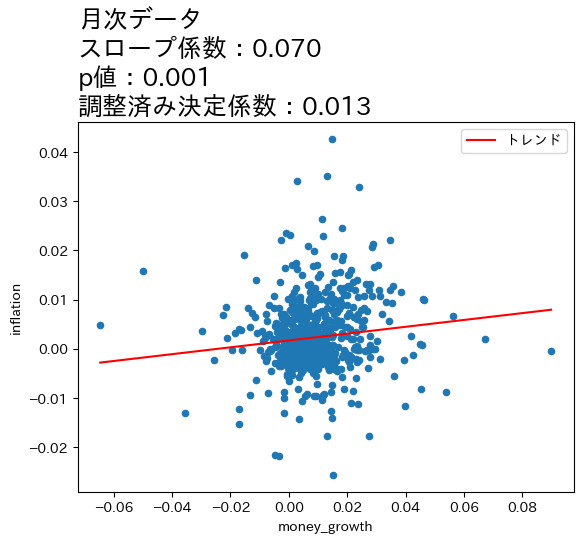

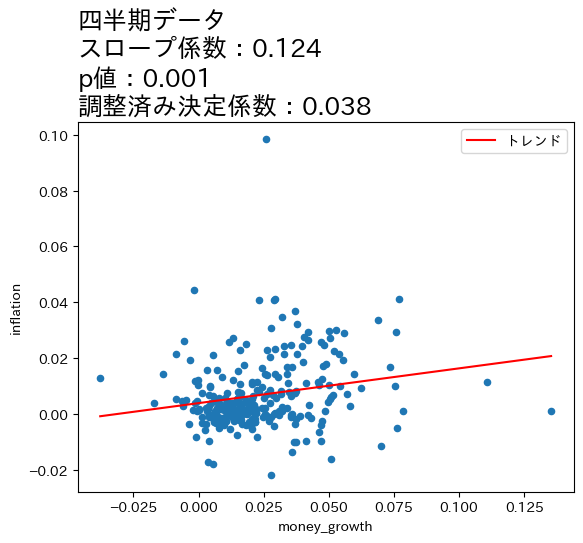

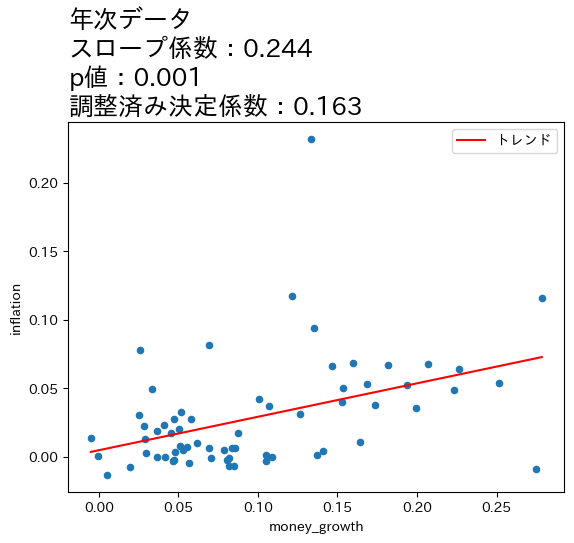

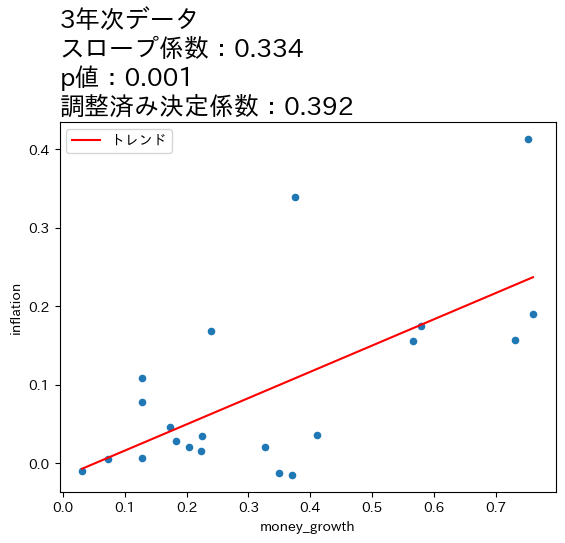

In [45]:
title_lst = ['月次データ','四半期データ','年次データ','3年次データ']       #1

for df, t in zip(df_lst,title_lst):
    
    res = smf.ols('inflation ~ money_growth', data=df).fit()        #2
    df['トレンド'] = res.fittedvalues                                #3
    
    ax_ = df.plot.scatter(x='money_growth', y='inflation')          #4
    df.sort_values('トレンド').plot(x='money_growth', y='トレンド',    #5
                                   color='r', ax=ax_)               #6
    ax_.set_title(f'{t}\n'                                          #7
                  f'スロープ係数：{res.params.iloc[1]:.3f}\n'               #8
                  f'p値：{res.pvalues.iloc[1]:.3f}\n'                     #9
                  f'調整済み決定係数：{res.rsquared_adj:.3f}',         #10
                  size=18, loc='left')                              #11

```{admonition} コード説明
:class: dropdown

1. それぞれのプロットのタイトルのリスト。
2. 最小二乗法の結果を変数`res`に割り当てる。
3. `res.fittedvalues`はOLSの予測値であり，新たな列としてそれぞれの`DataFrame`に追加する。その際の列名を`トレンド`とする。
4. 散布図を描き，生成される「軸」を`ax_`に割り当てる。
5. トレンド線を描く。`.sort_values('トレンド')`を使って列`トレンド`を昇順に並び替える。
6. `color='r'`は色を赤に指定する。
7. `ax=ax_`はトレンド線を描く際，「軸」`ax_`を使うことをしてしている。`f-string`を使ってタイトルを`{t}`に代入している。
8. `f-string`を使ってスロープ係数の推定値を代入している。
    * `.pvalues`は推定値を抽出する`res`のメソッドであり，１番目の要素であるスロープ係数を`[1]`で指定している。
    * `:.3f`は小数点第三位まで表示することを指定している。
9. p値に関して(8)と同じことを行なっている。
10. 調整済み決定係数に対して(8)と同じことを行なっている。
11. `loc`はタイトルの位置を設定する引数。
    * `'left'`は左寄せ
    * `'right'`は右寄せ
    * `'center'`は中央（デフォルト）
```

上の図とOLSの推定結果から次のことが分かる。
* 全てのケースで統計的優位性は高い。
* データの期間が長くなるとともに，スロープ係数の値が増加し，調整済み決定係数も高くなっている。

これらのことからマネーストックの変化の影響は，より長い期間をかけてインフレへの影響が発生していることが伺える。この結果は，式[](eq:11-qtm_growth_long)は長期的に成立することと整合的であると言えそうだ。

一方で，式[](eq:11-qtm_growth_long)は係数が`1`になることを予測しているが，上の4つのケースの係数は全て`1`よりも低い値となっている。この点を念頭に，次の節では日本だけではなく`170`国以上のデータを使い，問題を再検討することにする。また，OLS結果は因果関係を示しておらず単なる相関関係を表していることは念頭に置いておこう。

```{note}
４つの図の縦軸・横軸の値を比べると，データが長くなるにつれて値が大きくなることがわかる。期間が長くなると`cpi`と`M1`の増加率も上昇するためである。注意してほしいのは，増加率が上昇したために正の相関が強くなったという訳ではなく，増加率がより高くなっても正の相関は弱いまま，もしくは相関が存在しない場合もあり得る。図が示しているのは，データの期間が長くなるとより強い正の相関が「炙り出される」ということである。
```

## 世界経済のパネルデータ

### 説明

前節では日本のデータを使い，インフレ率に対するマネーストック増加率の影響が現れるには時間が掛かることを示した。一方でトレンド線の傾き（回帰分析のスロープ）は１よりも小さいが，式[](eq:11-qtm_growth_long)は線形であり，$m_t$の計数は１である。即ち，マネーストックの増加率が1％上昇するとインフレ率も1％増加するという予測である。データと理論予測の齟齬をどう考えれば良いだろうか。一つの問題はノイズである。年次データであっても3年次データであってもその期間に短期的なありとあらゆるランダムな要素（ノイズ）が含まれている。ノイズは正や負の両方の影響があると考えられ，その分変化が激しいと思われる。長期的な関係は，正と負の影響が相殺し，その結果残った関係と考えることができる。この考えをデータで捉えるためにデータ全体の平均を計算すれば良いことになる。しかし前節で使用した日本の1955年から2020年のデータを使い，インフレ率とマネーストトック増加率の平均を計算すると，標本の大きさは`１`となってしまう。これではどうしようもないので，国数を増やし，観測値を増やす必要がある。従って，ここでは世界経済のパネルデータを使い２変数の関係を探ることにする。

`py4macro`に含まれる`world-money`というデータ・セットを使うが，その内容は次のコードで確認できる。

In [46]:
py4macro.data('world-money',description=1)


    | `iso`:          ISO国コード
    | `country`:      国名
    | `year`:         年
    | `income_group`: 世界銀行が定義する所得グループ
    |   * High income
    |   * Upper Middle income
    |   * Lower Middle income
    |   * Low income
    | `money`:        マネーストック（M1）
    | `deflator`:     GDPディフレーター
    |
    | * 年次データ
    |
    | ＜注意点＞
    | * `money`と`deflator`が10年間以上連続で欠損値がない経済（177ヵ国）のみが含まれている。
    | * 国によって含まれるデータの`year`が異なる。
    | * 所得グループに関する情報
    |   https://datahelpdesk.worldbank.org/knowledgebase/articles/906519-world-bank-country-and-lending-groups
    |
    | ＜出典＞
    | World Bank Development Indicators


国によってデータが使える期間が異なることに注意しよう。

まず変数`world`にデータを割り当てる。

In [47]:
world = py4macro.data('world-money')
world.head()

,iso,country,year,income_group,money,deflator
0,ALB,Albania,1994,Upper middle income,3.876590e+10,35.739368
1,ALB,Albania,1995,Upper middle income,5.925260e+10,39.302820
2,ALB,Albania,1996,Upper middle income,9.040510e+10,54.305537
3,ALB,Albania,1997,Upper middle income,9.166720e+10,60.409306
4,ALB,Albania,1998,Upper middle income,8.372854e+10,64.475001


いつも通り`.info()`を使って内容を確かめてみよう。

In [48]:
world.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6584 entries, 0 to 6583
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   iso           6584 non-null   object 
 1   country       6584 non-null   object 
 2   year          6584 non-null   int64  
 3   income_group  6584 non-null   object 
 4   money         6584 non-null   float64
 5   deflator      6584 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 308.8+ KB


欠損値はないことが確認できる。

### 変化率の計算

`world`には経済ごとに10年以上に渡ってインフレ率とマネーストック増加率が含まれている。国ごとの変数の変化率を計算するには，以前紹介した`.pivot()`を使うことも可能だが，少し回りくどい計算になっている。ここでは異なる方法として`.groupby()`を紹介する。`.groupby()`はグループ内で何らかの計算をする際に非常に便利なメソッドである。次のステップに従って説明する。
1. `DataFram`をどの変数でグループ化するかを指定し，グループ化計算用のオブジェクトを用意する。
    * ここでは経済ごとの平均を計算したいので，国`iso`（もしくは`country`）でグループ化する。
1. グループ計算したい列を選ぶ。
    * ここでは`money`と`deflation`となる。
1. どのような計算をしたいのかを指定する。
    * ここでは増加率なので`.pct_change()`を使う。

**＜ステップ１＞**<br>
グループ化用のオブジェクトの作成するためには`DataFrame`のメソッド`.groupby()`を使い，その引数にグループ化用の列を指定する。ここでは`world`を`iso`でグループ化した変数`world_group`に割り当てる。

In [49]:
world_group = world.groupby('iso')
world_group

`DataFrameGroupBy object`が生成されたことを知らせるメッセージである。このオブジェクトは`world`自体をグループ化計算用に変換したものであり，`DataFrame`のように`.loc[]`などのメソッドは用意されていないので注意しよう。

**＜ステップ２＞**<br>
グループ計算したいのは`money`と`deflator`である。同時に指定しても構わないが，ここでは一つずつ指定することにする。例として`money`を考えよう。列を指定するには`[]`を使う。

In [50]:
world_group['money']

`SeriesGroupBy object`が生成されたことを知らせるメッセージである。ステップ１で生成された`DataFrameGroupBy object`から`money`の箇所を取り出したグループ計算用オブジェクトである。`Series`となっていることから分かるように，`iso`でグループ化され列`money`専用のグループ計算オブジェクトである。

**＜ステップ３＞**<br>
グループ計算に平均を使いたいので，ステップ２のオブジェクトに`.pct_change()`をつか加えるだけである。

In [51]:
world_group['money'].pct_change()

0            NaN
1       0.528472
2       0.525758
3       0.013960
4      -0.086603
          ...   
6579    1.700756
6580   -0.538285
6581   -0.547881
6582    0.479342
6583    0.936070
Name: money, Length: 6584, dtype: float64

返されたのは国ごとに計算されたマネーストック増加率である。`Series`として返されているが，行の並びは`world`と同じである。従って，次のコードでマネーストック増加率の列を`world`に追加できる。

In [52]:
world['money_growth'] = world_group['money'].pct_change()*100
world.head()

,iso,country,year,income_group,money,deflator,money_growth
0,ALB,Albania,1994,Upper middle income,3.876590e+10,35.739368,NaN
1,ALB,Albania,1995,Upper middle income,5.925260e+10,39.302820,52.847219
2,ALB,Albania,1996,Upper middle income,9.040510e+10,54.305537,52.575752
3,ALB,Albania,1997,Upper middle income,9.166720e+10,60.409306,1.396050
4,ALB,Albania,1998,Upper middle income,8.372854e+10,64.475001,-8.660303


列`money_growth`が最後に追加さている。Albaniaの最初の行である0番目の行は`NaN`になっているが，増加率を計算する際に発生している。同様に，全ての国の最初の行には`NaN`が入っている（確かめてみよう）。

次にインフレ率を計算する。次のコードは上で説明した手順を１行で書いている。

In [53]:
world['inflation'] = world_group['deflator'].pct_change()*100

試しに，日本のデータだけを抽出してみよう。

In [54]:
world.query('iso=="JPN"')

,iso,country,year,income_group,money,deflator,money_growth,inflation
3022,JPN,Japan,1961,High income,4.102000e+12,24.337971,NaN,NaN
3023,JPN,Japan,1962,High income,6.090000e+12,25.360063,48.464164,4.199578
3024,JPN,Japan,1963,High income,7.702000e+12,26.757522,26.469622,5.510469
3025,JPN,Japan,1964,High income,8.704000e+12,28.183351,13.009608,5.328706
3026,JPN,Japan,1965,High income,1.028700e+13,29.631090,18.187040,5.136857
3027,JPN,Japan,1966,High income,1.171600e+13,31.104013,13.891319,4.970869
3028,JPN,Japan,1967,High income,1.336900e+13,32.813300,14.108911,5.495390
3029,JPN,Japan,1968,High income,1.515500e+13,34.427341,13.359264,4.918863
3030,JPN,Japan,1969,High income,1.828200e+13,35.953642,20.633454,4.433399
3031,JPN,Japan,1970,High income,2.421400e+13,44.213162,32.447216,22.972693


上で説明したように，列`money_growth`と`inflation`の0番目の行の要素は`NaN`となっている。

### ハイパーインフレ

ハイパーインフレの確固たる定義はないが，Mankiwの教科書「マクロ経済学」では年率50％以上と定義している。この定義に基づき，ハイパーインフレは観測値の何％を占めるかを計算してみよう。まず`inflation`で`NaN`ではない行の数を数える。

In [55]:
notna = world.loc[:,'inflation'].notna().sum()
notna

6407

```{admonition} コードの説明
:class: dropdown

欠損値である`NaN`は`na`（not available）とも呼ばれる。メソッド`.notna()`は文字通り`na`ではない要素には`True`を`na`である要素には`False`を返す。`.sum()`は`True`の数を合計している。
```

`inflation`の値が`NaN`ではない行数を確認した。次に`inflation`が50％以上の行数を数えてみよう。

In [56]:
hyper = len( world.query('inflation >= 50') )
hyper

300

In [57]:
print(f'観測値の{100*hyper/notna:.2f}％でハイパーインフレが発生している。')

観測値の4.68％でハイパーインフレが発生している。


次に`inflation`の上位5ヵ国を表示してみよう。

In [58]:
world.sort_values('inflation', ascending=False).head()

,iso,country,year,income_group,money,deflator,money_growth,inflation
1413,COD,"Congo, Dem. Rep.",1994,Low income,3725130.0,0.001219,5635.381062,26765.858252
4277,NIC,Nicaragua,1988,Lower middle income,33480.0,0.000091,11673.429423,13611.634819
680,BOL,Bolivia,1985,Lower middle income,111800000.0,17.094034,3587.821612,12338.622324
4719,PER,Peru,1990,Upper middle income,707331500.0,3.608738,6724.820224,6261.239559
4279,NIC,Nicaragua,1990,Lower middle income,52778530.0,0.223530,6286.714344,5016.107950


トップはコンゴ共和国（COD）の年率26,766％！しかし，この数字はあまりピンとこないかもしれないので，次式を使って一日のインフレ率に換算してみよう。

$$
(1+g_{{日}})^{365}=1+g_{\text{年}}
\quad\Rightarrow\quad
g_{{日}}=(1+g_{\text{年}})^{\frac{1}{365}}-1
$$

ここで$g_{{年}}$は年率のインフレ率であり，$g_{{日}}$は1日当たりのインフレ率。この式を使い１に当たりの平均インフレ率を計算してみる。

In [59]:
inflation_cod = world.query('(iso=="COD") & (year==1994)').loc[:,'inflation']

inflation_cod_day = 100*( 
    ( 1+inflation_cod/100 )**( 1/365 )-1 
)

inflation_cod_day

1413    1.544252
Name: inflation, dtype: float64

1日平均約`1.54`％のインフレ率となる。次に１ヶ月間のインフレ率を計算してみよう。

In [60]:
100*( 
    ( 1+inflation_cod/100 )**( 1/12 )-1 
)

1413    59.379842
Name: inflation, dtype: float64

月平均では`60`％近くのインフレ率となる。

1日平均約`1.54`％をもう少し身近に感じられるように，日本と比較してみよう。バブル景気崩壊直後の`1995`年と`2023`年の消費者物価指数（総合）は、それぞれ`95.9`と`105.6`である（[このページのデータを参照](https://www.e-stat.go.jp/stat-search/files?page=1&layout=datalist&toukei=00200573&tstat=000001150147&cycle=0&tclass1=000001150151&tclass2=000001150152&tclass3=000001150153&tclass4=000001150154&tclass5val=0)）。年平均（幾何平均）は次のようになる。

In [61]:
jp_inflation = 100 * ( (105.6 / 95.9)**( 1/(2023-1995) ) - 1 )
print(f'1995-2023年の年平均インフレ率（消費者物価指数）：{jp_inflation:.2f}％')

1995-2023年の年平均インフレ率（消費者物価指数）：0.34％


日本のインフレ率も非常に低いと言わざるを得ないが、日本の`29`年間の**年**平均インフレ率よりも高い率で**毎日**インフレが発生するのは、大変な事だろうと想像に難しくないのではないだろうか。別の考え方として，物価が２倍になるには何日かかるかを考えてみよう。$t$日後に物価は２倍になるとすると，次式が成立する。

$$
2=(1+g_{\text{日}})^t
\quad\Rightarrow\quad
t=\frac{\log(2)}{\log(1+g_{\text{日}})}
$$

この式を使って$t$を計算してみよう。

In [62]:
np.log(2) / np.log( 1+inflation_cod_day/100 )

1413    45.231317
Name: inflation, dtype: float64

約`45`日間で物価は`2`倍になることが分かる。例えば、`10`万円するPCやスマホが、`45`日後には`20`万円になっているという状況である。

### プロット

全てのデータを使って散布図をプロットしトレンドを計算してみる。

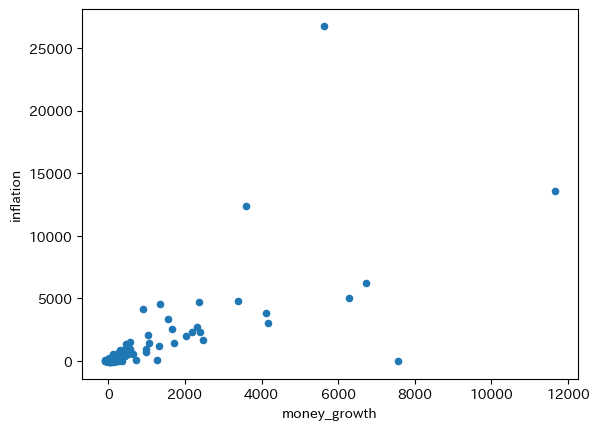

In [63]:
world.plot.scatter(x='money_growth', y='inflation')
pass

```{admonition} コードの説明
:class: dropdown

`world`には`inflation`と`money_growth`が`NaN`となっている行が含まれるが，上の図では自動的に省かれる。`world.dropna().plot()`としても図は変わらない。
```

横軸と縦軸の値（％）を確認してみると分かるが非常に大きい。ノイズの影響により変化が非常に激しいためである。トレンドのスロープを計算してみよう。

In [64]:
res_world = smf.ols('inflation ~ money_growth', data=world).fit()
print(f'標本の大きさ：{int(res_world.nobs)}')
print(f'調整済み決定係数：{res_world.rsquared_adj:.3f}')
res_world.summary().tables[1]

標本の大きさ：6407
調整済み決定係数：0.537


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-9.6447,3.843,-2.510,0.012,-17.178,-2.112
money_growth,1.2802,0.015,86.259,0.000,1.251,1.309


トレンドのスロープは1.28であり，1に近いがノイズの影響が大きいようである。

この結果と比較したいのが，次のケースである。
* それぞれの国で`inflation`と`money_growth`の平均を計算し，その散布図をプロットするとともに傾きを計算する。

まず，それぞれの経済の２変数の平均を計算するが，一つ注意点がある。`world`に`inflation`と`money_growth`があるので，`.mean()`を使って平均を計算すれば良いと思うかもしれない。しかし`.mean()`は算術平均であり，計算したいのは増加率の平均なので可能であれば幾何平均を使うべきである。残念ながら，`DataFrame`には幾何平均のメソッドが良いされて良いないので，次のように`for`ループで計算することにする。

In [65]:
money_growth_mean_lst = []                   # 1
inflation_mean_lst = []                      # 2
iso_lst = []                                 # 3 
country_lst = []                             # 4
income_group_lst = []                        # 5

for c in world.loc[:,'iso'].unique():         # 6
    df = world.query('iso==@c').reset_index() # 7
    n = len(df)                               # 9
    
    money_growth_mean = 100*(                 # 9
        (df.loc[n-1,'money']/df.loc[0,'money'])**(1/(n-1))-1
    )
    inflation_mean = 100*(                    # 10
        (df.loc[n-1,'deflator']/df.loc[0,'deflator'])**(1/(n-1))-1
    )
                                              # 11
    money_growth_mean_lst.append(money_growth_mean)
    inflation_mean_lst.append(inflation_mean)
    iso_lst.append(c)
                                              # 12
    country_lst.append(df.loc[:,'country'].unique()[0])
    
                                              # 13
    income_group_lst.append(df.loc[:,'income_group'].unique()[0])
    
                                              # 14
world_mean = pd.DataFrame({'country':country_lst,
                           'income_group':income_group_lst,
                           'money_growth_mean':money_growth_mean_lst,
                           'inflation_mean':inflation_mean_lst,
                           'iso':iso_lst}).set_index('iso')

```{admonition} コードの説明
:class: dropdown

1. マネーストックの平均増加率を格納する空のリスト。
2. 平均インフレ率を格納する空のリスト。
3. 国のisoを格納する空のリスト。
4. 国名を格納するリスト。
5. 所得グループ名を格納するリスト。
6. データにある経済全てに対しての`for`ループを開始
    * `world.loc[:,'iso']`は列`iso`を抽出し，`.unique()`を使って経済のリストを作成する。
7. `.query('iso==@c')`で`c`国の行だけを抽出し，`reset_index()`で行インデックスを振り直す。`c`国の`DataFrame`を`df`に割り当てる。
8. `df`の行数を`n`に割り当てる。
9. `df`の列`money`の最初と最後の行の値を使って平均増加率を計算する。`100*`で％表示にする。
10. `df`の列`deflator`の最初と最後の行の値を使って平均インフレ率を計算する。`100*`で％表示にする。
11. `money_growth_mean`，`inflation_mean`，`c`をそれぞれ対応するリストに追加する。
12. 国名を`country_list`に追加する。
    * `df.loc[:,'country']`で列`country`を抽出し，`.unique()`で国名が入る`array`が返される。`[0]`はその0番目の要素を抽出している。
13. 所得グループ名を`income_group_list`に追加する。
    * `df.loc[:,'income_group']`で列`income_group`を抽出し，`.unique()`でグループ名が入る`array`が返される。`[0]`はその0番目の要素を抽出している。
14. `money_growth_mean_list`，`inflation_mean_list`，`country_list`を使い`DataFrame`を作成し`world_mean`に割り当てる。`.set_index('iso')`は`iso`を行ラベルに設定している。
```

````{tip}
実は`.groupby()`使って幾何平均を計算することも可能である。例えば，次のコードでマネーストック増加率の幾何平均を計算できる。
```
from scipy.stats import gmean            # 1

world.groupby('iso')['money'].agg(gmean) # 2
```
簡単なコードで良いが，(1)にある関数を導入する必要があり，また(2)の`.agg()`を使う必要がある。上のコードは`for`ループに慣れることを一つの目的としている。
````

平均でハイパーインフレが発生している国は何ヵ国なるのか計算してみよう。

In [66]:
hyper = ( world_mean.loc[:,'inflation_mean'] >= 50 ).sum()

print(f'{len(world_mean)}ヵ国中{hyper}ヵ国でハイパーインフレが発生している。')

177ヵ国中7ヵ国でハイパーインフレが発生している。


```{admonition} コードの説明
:class: dropdown

* `world_mean.loc[:,'inflation_mean']`で`inflation_mean`の列を抽出。
* `world_mean.loc[:,'inflation_mean'] >= 50`を使い，列`inflation_mean`の要素が50以上であれば`True`，50未満であれば`False`となる`Series`を返す。
* `True`は１，`False`は０と等しいので，`.sum()`で合計することによってハイパーインフレ国の数が計算できる。
```

短期的なノイズの影響によってある年にハイパーインフレが発生する場合もあるだろう。しかしこの結果は，長期的にハイパーインフレに悩まされる国が存在することを示している。どのような国なのかを確認するために，インフレ率上位10ヵ国を表示してみよう。

In [67]:
world_mean.sort_values(by='inflation_mean', ascending=False).head(10)

,country,income_group,money_growth_mean,inflation_mean
iso,,,,
COD,"Congo, Dem. Rep.",Low income,122.442962,127.704505
AGO,Angola,Lower middle income,108.457354,92.231798
BRA,Brazil,Upper middle income,92.023344,88.882771
ARG,Argentina,Upper middle income,79.169900,74.971614
NIC,Nicaragua,Lower middle income,67.774841,62.717663
BLR,Belarus,Upper middle income,65.667637,62.536094
UKR,Ukraine,Lower middle income,58.537270,61.867179
PER,Peru,Upper middle income,54.905117,48.305760
ARM,Armenia,Upper middle income,48.970412,46.680070


やはり所得水準が比較的に低い国が入っている。

`world_mean`を使いクロスセクションのデータをプロットしてみよう。

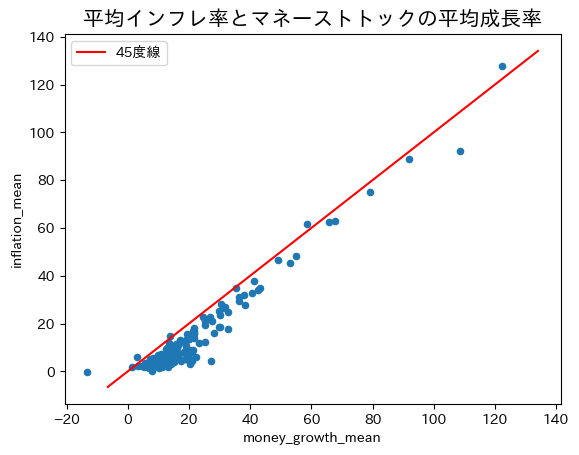

In [68]:
ax_ = world_mean.plot.scatter(x='money_growth_mean', y='inflation_mean')
xpoints = ypoints = ax_.get_ylim()
ax_.plot(xpoints,ypoints,'r-', label='45度線')
ax_.set_title('平均インフレ率とマネーストトックの平均成長率', size='15')
ax_.legend()
pass

綺麗に45度線上に並んでいる。国ごとに平均を計算することによって短期的なノイズが相殺され長期的な関係が浮かび上がっている。トレンド線の傾きを計算してみよう。

In [69]:
res_world_mean = smf.ols('inflation_mean ~ money_growth_mean', data=world_mean).fit()
print(f'標本の大きさ：{int(res_world_mean.nobs)}')
print(f'調整済み決定係数：{res_world_mean.rsquared_adj:.3f}')
print(res_world_mean.summary().tables[1])

標本の大きさ：177
調整済み決定係数：0.945
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -6.0805      0.461    -13.175      0.000      -6.991      -5.170
money_growth_mean     0.9847      0.018     54.876      0.000       0.949       1.020


推定値は１に非常に近い。もし図の左下にある外れ値のように見える値（ジンバブエ）を省くとスロープ係数は0.997になる。長期的には式[](eq:11-qtm_growth_long)が示すように，マネーストック増加率の1％上昇はインフレ率1％上昇につかがること示す結果である。「真のメカニズム」の一部が垣間見えるような気がしませんか。